# Web scraping and data analysis of an F1 season with Beautiful Soup and Pandas

# Drivers Championship Analysis

In [2]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install urllib

ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install html5lib

     |████████████████████████████████| 112 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
source = urllib.request.urlopen('https://www.formula1.com/en/results.html/1990/drivers.html').read()
soup = BeautifulSoup(source,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.head()
df.drop(["Unnamed: 0","Unnamed: 6"],axis=1, inplace=True)
df.head()


,Pos,Driver,Nationality,Car,PTS
0,1,Ayrton Senna SEN,BRA,McLaren Honda,78
1,2,Alain Prost PRO,FRA,Ferrari,71
2,3,Nelson Piquet PIQ,BRA,Benetton Ford,43
3,3,Gerhard Berger BER,AUT,McLaren Honda,43
4,5,Nigel Mansell MAN,GBR,Ferrari,37


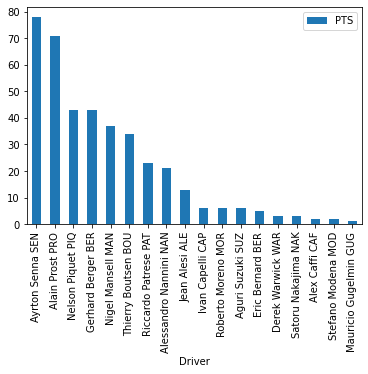

In [3]:
df.plot.bar(x="Driver", y="PTS");

In [4]:
source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/1990/races/64/united-states/race-result.html").read()
soup = BeautifulSoup(source,'lxml')

table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.head()

,Unnamed: 0,Pos,No,Driver,Car,Laps,Time/Retired,PTS,Unnamed: 8
0,NaN,1,27,Ayrton Senna SEN,McLaren Honda,72,1:52:32.829,9,NaN
1,NaN,2,4,Jean Alesi ALE,Tyrrell Ford,72,+8.685s,6,NaN
2,NaN,3,5,Thierry Boutsen BOU,Williams Renault,72,+54.080s,4,NaN
3,NaN,4,20,Nelson Piquet PIQ,Benetton Ford,72,+68.358s,3,NaN
4,NaN,5,8,Stefano Modena MOD,Brabham Judd,72,+69.503s,2,NaN


In [5]:
year=1990
year=str(year)

In [6]:
def get_race_urls(year):
    race_urls=[]
    source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/{year}/"f"races.html").read()
    soup = BeautifulSoup(source,'lxml')
    for url in soup.find_all('a'):
        if year in str(url.get('href')) and 'race-result' in str(url.get('href')) and url not in race_urls:
            race_urls.append(str(url.get('href')))
    return race_urls
            
    

In [7]:
#collect_urls(year)
HOMEPAGE="https://www.formula1.com"


In [8]:
race_urls = get_race_urls(year)
season_results_df = None

def seasons_results(race_urls):

    for n, race in enumerate(race_urls):

        placeholder = [0 for i in range(n)]
        race_name = race.split('/')[6]

        results_page = urllib.request.urlopen(f"{HOMEPAGE}{race}").read()
        race_results = BeautifulSoup(results_page,'lxml')

        table = race_results.find_all('table')[0] 
        df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
        df.drop(["Unnamed: 0","Unnamed: 8"], axis=1, inplace=True)
        df.set_index('No', inplace=True)

        #establish season results df on first race information
        if n == 0:
            season_results_df = pd.DataFrame(df[['Driver','Car']], columns=['Driver','Car'], index=df.index)
       
        #add drivers if they are not in season_results_df
        for ind in df.index.difference(season_results_df.index):
            season_results_df.loc[ind] = [df['Driver'].loc[ind],df['Car'].loc[ind],*placeholder]

        for ind in df.index:
            pts = df['PTS'].where(df.index == ind).dropna().values[0]
            season_results_df.loc[ind, race_name] = int(pts)
    
    season_results_df.sort_index(inplace=True)
    season_results_df.fillna(0, inplace=True)   
    season_results_df['Car'] = season_results_df['Car'].apply(lambda s : s[:3]).map(str.upper) #retain last 3 digits and caps
    return season_results_df 


In [25]:
season_results_df=seasons_results(race_urls)
#season_results_df

In [26]:
cum_results = season_results_df.drop(['Driver', 'Car'], axis=1).cumsum(axis=1)
#cum_results

In [29]:
cum_results['Driver'] = season_results_df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
#cum_results

In [30]:
cum_results.sort_values(by='australia',ascending=False, inplace=True)
#cum_results

In [31]:
cum_results.set_index('Driver', inplace=True)
cum_results.head()

,united-states,brazil,san-marino,monaco,canada,mexico,france,great-britain,germany,hungary,belgium,italy,portugal,spain,japan,australia
Driver,,,,,,,,,,,,,,,,
SEN,9.0,13.0,13.0,22.0,31.0,31.0,35.0,39.0,48.0,54.0,63.0,72.0,78.0,78.0,78.0,78.0
PRO,0.0,9.0,12.0,12.0,14.0,23.0,32.0,41.0,44.0,44.0,50.0,56.0,60.0,69.0,69.0,73.0
PIQ,3.0,4.0,6.0,6.0,12.0,13.0,16.0,18.0,18.0,22.0,24.0,24.0,26.0,26.0,35.0,44.0
BER,0.0,6.0,12.0,16.0,19.0,23.0,25.0,25.0,29.0,29.0,33.0,37.0,40.0,40.0,40.0,43.0
MAN,0.0,3.0,3.0,3.0,7.0,13.0,13.0,13.0,13.0,13.0,13.0,16.0,25.0,31.0,31.0,37.0


<Figure size 1008x576 with 0 Axes>

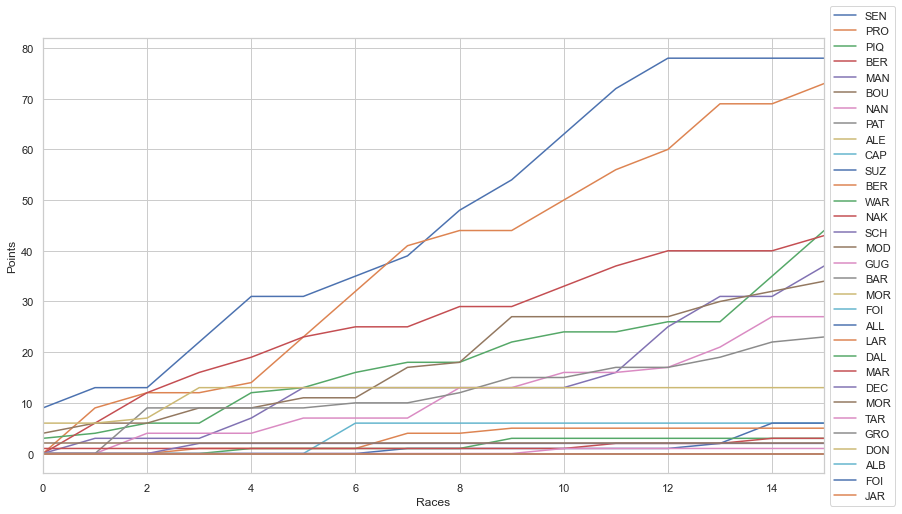

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(14,8))
#ax = fig.add_subplot(1, 1, 1) 
cum_results.transpose().plot.line(figsize=(14,8),use_index=False,xlim=(0,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")
plt.show()

# Using best 11

In [47]:
import numpy as np
def best_11_cumsum(season_results_df):
    series = season_results_df.drop(['Driver', 'Car'])#.drop(['Driver', 'Car'], axis=1).iloc[0]
    best_11_cum = np.array(series[:11].cumsum())
    best_11_S = series[:11].sort_values()
    best_11 = np.array(series[:11].sort_values())
    
    for pts in series[11:]:
        if pts > best_11_S.any():
            best_11 = np.delete(best_11,0)
            best_11 = np.insert(best_11, -1, pts)
            
            best_11_cum = np.insert(best_11_cum, len(best_11_cum), np.array(best_11).cumsum()[-1])
            
        else:
            best_11_cum = np.insert(best_11_cum, len(best_11_cum), best_11_cum[-1])
            
    return best_11_cum
  
df = season_results_df.apply(best_11_cumsum, axis=1)#apply functino to DataFrame

# above returns a pd.Series of arrays so reformatting is required:
df = season_results_df.apply(best_11_cumsum, axis=1)
df = pd.DataFrame(pd.DataFrame(df)[0].tolist(), columns=season_results_df.columns[2:])
df['Driver'] = season_results_df['Driver'].values
df['Driver'] = df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
cols_new = list(df.columns[-1:]) + list(df.columns[:-1])
df = df[cols_new]
df.sort_values(by='australia',ascending=False, inplace=True)
df.set_index('Driver', inplace=True)

df.head()


,united-states,brazil,san-marino,monaco,canada,mexico,france,great-britain,germany,hungary,belgium,italy,portugal,spain,japan,australia
Driver,,,,,,,,,,,,,,,,
SEN,9.0,13.0,13.0,22.0,31.0,31.0,35.0,39.0,48.0,54.0,63.0,72.0,78.0,78.0,78.0,78.0
PRO,0.0,9.0,12.0,12.0,14.0,23.0,32.0,41.0,44.0,44.0,50.0,56.0,60.0,69.0,69.0,71.0
PIQ,3.0,4.0,6.0,6.0,12.0,13.0,16.0,18.0,18.0,22.0,24.0,24.0,26.0,26.0,35.0,43.0
BER,0.0,6.0,12.0,16.0,19.0,23.0,25.0,25.0,29.0,29.0,33.0,37.0,40.0,40.0,40.0,43.0
MAN,0.0,3.0,3.0,3.0,7.0,13.0,13.0,13.0,13.0,13.0,13.0,16.0,25.0,31.0,31.0,37.0


# Driver Form

In [52]:
#season_results_df

Text(0, 0.5, 'Points')

<Figure size 1008x576 with 0 Axes>

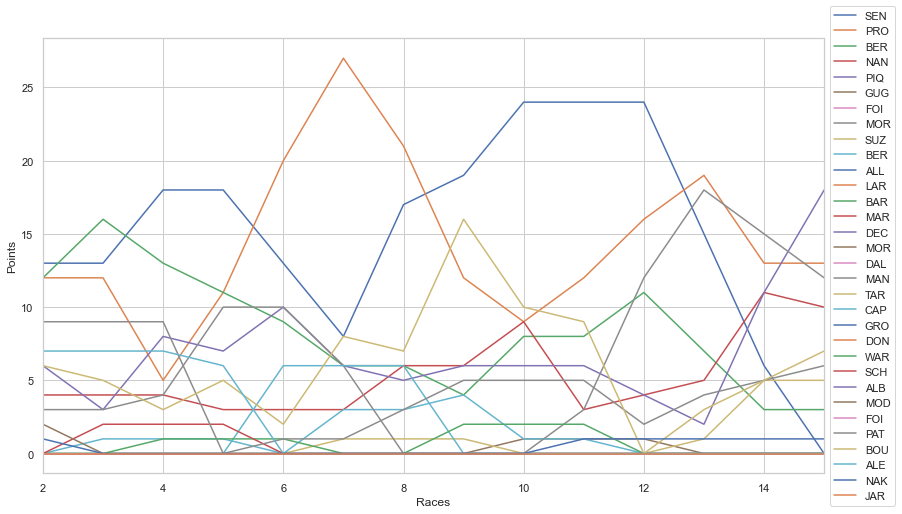

In [48]:
season_results_df['Driver'] = season_results_df['Driver'].apply(lambda s : s[-3:]).map(str.upper)
season_results_df.sort_values(by='belgium',ascending=False, inplace=True)
season_results_df.set_index('Driver', inplace=True)
season_results_df.drop('Car', axis=1,  inplace=True)

fig = plt.figure(figsize=(14,8))
sns.set(style='whitegrid')

ax = season_results_df.transpose().rolling(3).sum().plot(figsize=(14,8),use_index=False, xlim=(2,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")

# Constructors Championship Analysis

In [155]:
source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/{year}/"f"drivers.html").read()
soup = BeautifulSoup(source,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.head()
df.drop(["Unnamed: 0","Unnamed: 6"],axis=1, inplace=True)
df.head()

,Pos,Driver,Nationality,Car,PTS
0,1,Ayrton Senna SEN,BRA,McLaren Honda,78
1,2,Alain Prost PRO,FRA,Ferrari,71
2,3,Nelson Piquet PIQ,BRA,Benetton Ford,43
3,3,Gerhard Berger BER,AUT,McLaren Honda,43
4,5,Nigel Mansell MAN,GBR,Ferrari,37


In [156]:
df.drop(["Pos","Driver","Nationality"],axis=1, inplace=True)
df.head()

,Car,PTS
0,McLaren Honda,78
1,Ferrari,71
2,Benetton Ford,43
3,McLaren Honda,43
4,Ferrari,37


### Sum of team points

In [157]:
df1=df.groupby(['Car'], sort=False).agg('sum')
df1

,PTS
Car,
McLaren Honda,121
Ferrari,108
Benetton Ford,70
Williams Renault,57
Tyrrell Ford,16
Leyton House Judd,7
Lola Lamborghini,11
Lotus Lamborghini,3
Arrows Ford,2


In [158]:
race_urls = get_race_urls(year)
season_results_df = None

def seasons_results(race_urls):

    for n, race in enumerate(race_urls):

        placeholder = [0 for i in range(n)]
        race_name = race.split('/')[6]

        results_page = urllib.request.urlopen(f"{HOMEPAGE}{race}").read()
        race_results = BeautifulSoup(results_page,'lxml')

        table = race_results.find_all('table')[0] 
        df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
        df.drop(["Unnamed: 0","Unnamed: 8"], axis=1, inplace=True)
        df.set_index('No', inplace=True)

        #establish season results df on first race information
        if n == 0:
            season_results_df = pd.DataFrame(df[['Driver','Car']], columns=['Driver','Car'], index=df.index)
       
        #add drivers if they are not in season_results_df
        for ind in df.index.difference(season_results_df.index):
            season_results_df.loc[ind] = [df['Driver'].loc[ind],df['Car'].loc[ind],*placeholder]

        for ind in df.index:
            pts = df['PTS'].where(df.index == ind).dropna().values[0]
            season_results_df.loc[ind, race_name] = int(pts)
    
    season_results_df.sort_index(inplace=True)
    season_results_df.fillna(0, inplace=True)   
    season_results_df['Car'] = season_results_df['Car'].apply(lambda s : s[:3]).map(str.upper) #retain last 3 digits and caps
    return season_results_df 


In [159]:
season_results_df=seasons_results(race_urls)
df2=season_results_df

In [160]:
cum_results = season_results_df.drop(['Driver','Car'], axis=1).cumsum(axis=1)
#cum_results

In [161]:
cum_results['Car']=season_results_df['Car']
#cum_results

In [162]:
cum_results.sort_values(by='australia',ascending=False, inplace=True)
#cum_results

In [163]:
cum_results.set_index('Car', inplace=True)
cum_results.head()

,united-states,brazil,san-marino,monaco,canada,mexico,france,great-britain,germany,hungary,belgium,italy,portugal,spain,japan,australia
Car,,,,,,,,,,,,,,,,
MCL,9.0,13.0,13.0,22.0,31.0,31.0,35.0,39.0,48.0,54.0,63.0,72.0,78.0,78.0,78.0,78.0
FER,0.0,9.0,12.0,12.0,14.0,23.0,32.0,41.0,44.0,44.0,50.0,56.0,60.0,69.0,69.0,73.0
BEN,3.0,4.0,6.0,6.0,12.0,13.0,16.0,18.0,18.0,22.0,24.0,24.0,26.0,26.0,35.0,44.0
MCL,0.0,6.0,12.0,16.0,19.0,23.0,25.0,25.0,29.0,29.0,33.0,37.0,40.0,40.0,40.0,43.0
FER,0.0,3.0,3.0,3.0,7.0,13.0,13.0,13.0,13.0,13.0,13.0,16.0,25.0,31.0,31.0,37.0


In [165]:
df1=cum_results.groupby(['Car'], sort=False).agg('sum')
df1= df1[df1['australia'] != 0]
df1

,united-states,brazil,san-marino,monaco,canada,mexico,france,great-britain,germany,hungary,belgium,italy,portugal,spain,japan,australia
Car,,,,,,,,,,,,,,,,
MCL,9.0,19.0,25.0,38.0,50.0,54.0,60.0,64.0,77.0,83.0,96.0,109.0,118.0,118.0,118.0,121.0
FER,0.0,12.0,15.0,15.0,21.0,36.0,45.0,54.0,57.0,57.0,63.0,72.0,85.0,100.0,100.0,110.0
BEN,3.0,4.0,10.0,10.0,16.0,20.0,23.0,25.0,31.0,35.0,40.0,40.0,43.0,47.0,62.0,71.0
WIL,4.0,6.0,15.0,18.0,18.0,20.0,21.0,27.0,30.0,42.0,42.0,44.0,44.0,49.0,54.0,57.0
TYR,7.0,7.0,8.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,15.0,15.0,15.0,16.0,16.0
LEY,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0
LOL,0.0,0.0,0.0,1.0,1.0,1.0,1.0,5.0,5.0,6.0,6.0,6.0,6.0,7.0,11.0,11.0
LOT,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
ARR,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


### Performace of teams over the course of the season

<Figure size 1008x576 with 0 Axes>

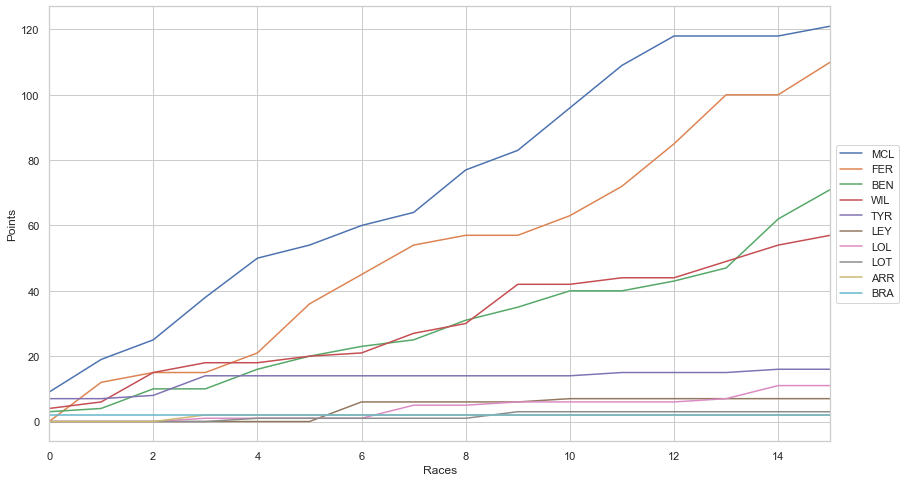

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(14,8))
#ax = fig.add_subplot(1, 1, 1) 
df1.transpose().plot.line(figsize=(14,8),use_index=False,xlim=(0,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")
plt.show()

### Form of teams

In [167]:
df3=df2

Text(0, 0.5, 'Points')

<Figure size 1008x576 with 0 Axes>

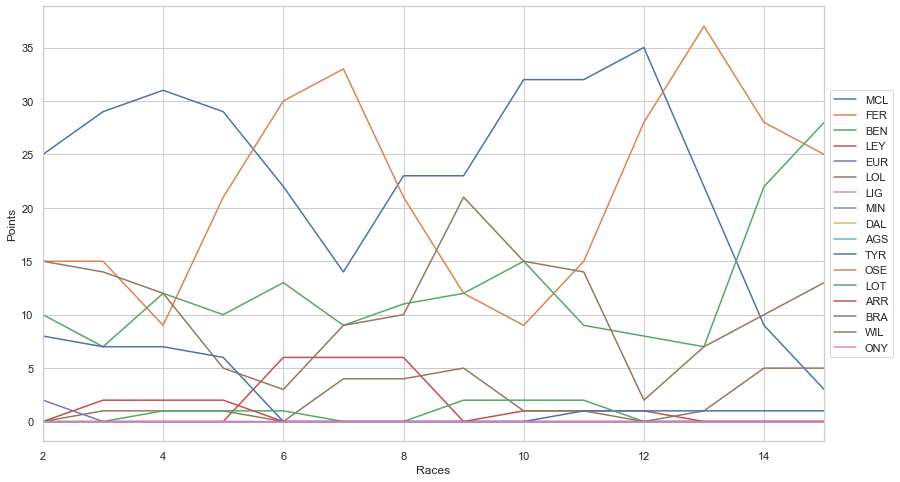

In [169]:
df3=df3.groupby(['Car'], sort=False).agg('sum')
df3.sort_values(by='belgium',ascending=False, inplace=True)

fig = plt.figure(figsize=(14,8))
sns.set(style='whitegrid')

ax = df3.transpose().rolling(3).sum().plot(figsize=(14,8),use_index=False, xlim=(2,15)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Races")
plt.ylabel("Points")